<p style="text-align:center">
    <a href="https://skills.network" target="_blank">
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/assets/logos/SN_web_lightmode.png" width="200" alt="Skills Network Logo">
    </a>
</p>

# Bootstrap Aggregating (Bagging) for classification with Python

Estimated time needed: **45** minutes

## Objectives

After completing this lab you will be able to:

*   Understand Bootstrap sampling
*   Understand  Model Instability
*   Apply Bagging
*   Understand when to use Bagging


In this notebook, you will learn the process of Bagging  (Bootstrap Aggregation)  models for classification. Bagging is a method for generating multiple model versions and aggregating the ensemble of models to make a single prediction. For classification, aggregation performs majority vote when predicting a class. The various versions of the model are formed by performing Bootstrap sampling of the training set and using these to train each model in the ensemble .


<h1>Table of contents</h1>

<div class="alert alert-block alert-info" style="margin-top: 20px">
    <ol>
        <li><a href="https://#about_dataset">About the dataset</a></li>
        <li><a href="https://#preprocessing">Data pre-processing and selection</a></li>
        <li><a href="https://#modeling">Modeling (Logistic Regression with Scikit-learn)</a></li>
        <li><a href="https://#evaluation">Evaluation</a></li>
        <li><a href="https://#practice">Practice</a></li>
    </ol>
</div>
<br>
<hr>


Let's first import required libraries:


In [1]:
# All Libraries required for this lab are listed below. The libraries pre-installed on Skills Network Labs are commented.
!pip install -qy pandas==1.3.3 numpy==1.21.2 ipywidgets==7.4.2 scipy==7.4.2 tqdm==4.62.3 matplotlib==3.5.0 seaborn==0.9.0
# Note: If your environment doesn't support "!mamba install", use "!pip install" 


Usage:   
  pip install [options] <requirement specifier> [package-index-options] ...
  pip install [options] -r <requirements file> [package-index-options] ...
  pip install [options] [-e] <vcs project url> ...
  pip install [options] [-e] <local project path> ...
  pip install [options] <archive url/path> ...

no such option: -y


In [2]:
!pip install --upgrade scikit-learn
!pip install pandas
!pip install numpy
!pip install matplotlib   
!pip install seaborn
!pip install pydotplus

In [3]:
# Library for reading in data and using dataframes
import pandas as pd
# Using numpy arrays
import numpy as np
# Data preprocessing functions like LabelEncoder
from sklearn import preprocessing
%matplotlib inline
# Visualizations
import matplotlib.pyplot as plt
# Model accuracy
from sklearn import metrics
# Surpress numpy data type warnings
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
# Give loops a progress bar
from tqdm import tqdm

This function calculates the train and test accuracy of a model


In [4]:
def get_accuracy(X_train, X_test, y_train, y_test, model):
    return  {"test Accuracy":metrics.accuracy_score(y_test, model.predict(X_test)),"train Accuracy": metrics.accuracy_score(y_train, model.predict(X_train))}

This function creates visualizations of decision trees


In [5]:
# Plot tree helper libraries
from  io import StringIO
import pydotplus
import matplotlib.image as mpimg
from sklearn import tree


def plot_tree(model,filename = "tree.png"):
    #global churn_df 

    dot_data = StringIO()
  

    featureNames = [colunm  for colunm in churn_df[['tenure', 'age', 'address', 'income', 'ed', 'employ', 'equip']].columns]
    out=tree.export_graphviz(model,feature_names=featureNames, out_file=dot_data, class_names= ['left','stay'], filled=True,  special_characters=True,rotate=False)  
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
    graph.write_png(filename)
    img = mpimg.imread(filename)
    plt.figure(figsize=(100, 200))
    plt.imshow(img,interpolation='nearest')

This function creates a graph of training accuracy vs how many estimators (Decision Trees) a BaggingClassifier uses


In [7]:
def get_accuracy_bag(X,y,title,times=20,xlabel='Number Estimators'):
    #Iterate through different number of estimators and average out the results  


    N_estimators=[n for n in range(1,70)]
    times=20
    train_acc=np.zeros((times,len(N_estimators)))
    test_acc=np.zeros((times,len(N_estimators)))
    
    train_time=np.zeros((times,len(N_estimators)))
    test_time=np.zeros((times,len(N_estimators)))
     #average out the results
    for n in tqdm(range(times)):
        X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.3)
        for n_estimators in N_estimators:
            #Iterate through different number of estimators and average out the results   
        
            Bag= BaggingClassifier(estimator=DecisionTreeClassifier(criterion="entropy", max_depth = 10),n_estimators=n_estimators,bootstrap=True,random_state=0)
            Bag.fit(X_train,y_train)
          
            
             
            Accuracy=get_accuracy(X_train, X_test, y_train, y_test,  Bag)
           
            
            
  
            train_acc[n,n_estimators-1]=Accuracy['train Accuracy']
            test_acc[n,n_estimators-1]=Accuracy['test Accuracy']
        
        
        
    fig, ax1 = plt.subplots()

    ax2 = ax1.twinx()
    ax1.plot(train_acc.mean(axis=0))
    ax2.plot(test_acc.mean(axis=0),c='r')
    ax1.set_xlabel(xlabel)
    ax1.set_ylabel('Training accuracy',color='b')
    ax2.set_ylabel('Testing accuracy', color='r')
    plt.title(title)
    plt.show()
    
   

## Customer churn

A telecommunications company is concerned about the number of customers leaving their land-line business for cable competitors. They need to understand who is leaving. Imagine that you are an analyst at this company and you have to find out why


### About the dataset

We will use a telecommunications dataset for predicting customer churn. This is a historical customer dataset where each row represents one customer. The data is relatively easy to understand, and you may uncover insights you can use immediately. Typically it is less expensive to keep customers than acquire new ones, so the focus of this analysis is to predict the customers who will stay with the company.

This data set provides information to help you predict what behavior will help you to retain customers. You can analyze all relevant customer data and develop focused customer retention programs.

The dataset includes information about:

*   Customers who left within the last month – the column is called Churn
*   Services that each customer has signed up for – phone, multiple lines, internet, online security, online backup, device protection, tech support, and streaming TV and movies
*   Customer account information – how long they had been a customer, contract, payment method, paperless billing, monthly charges, and total charges
*   Demographic info about customers – gender, age range, and if they have partners and dependents


### Load Data From CSV File


In [8]:
churn_df = pd.read_csv("https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/Module%203/data/ChurnData.csv")

churn_df.head()

,tenure,age,address,income,ed,employ,equip,callcard,wireless,longmon,...,pager,internet,callwait,confer,ebill,loglong,logtoll,lninc,custcat,churn
0,11.0,33.0,7.0,136.0,5.0,5.0,0.0,1.0,1.0,4.40,...,1.0,0.0,1.0,1.0,0.0,1.482,3.033,4.913,4.0,1.0
1,33.0,33.0,12.0,33.0,2.0,0.0,0.0,0.0,0.0,9.45,...,0.0,0.0,0.0,0.0,0.0,2.246,3.240,3.497,1.0,1.0
2,23.0,30.0,9.0,30.0,1.0,2.0,0.0,0.0,0.0,6.30,...,0.0,0.0,0.0,1.0,0.0,1.841,3.240,3.401,3.0,0.0
3,38.0,35.0,5.0,76.0,2.0,10.0,1.0,1.0,1.0,6.05,...,1.0,1.0,1.0,1.0,1.0,1.800,3.807,4.331,4.0,0.0
4,7.0,35.0,14.0,80.0,2.0,15.0,0.0,1.0,0.0,7.10,...,0.0,0.0,1.0,1.0,0.0,1.960,3.091,4.382,3.0,0.0


<h2 id="preprocessing">Data pre-processing and selection</h2>


Let's select some features for the modeling. Also, we change the target data type to be an integer, as it is a requirement by the skitlearn algorithm:


In [9]:
churn_df = churn_df[['tenure', 'age', 'address', 'income', 'ed', 'employ', 'equip',   'callcard', 'wireless','churn']]
churn_df['churn'] = churn_df['churn'].astype('int')
churn_df.head()

,tenure,age,address,income,ed,employ,equip,callcard,wireless,churn
0,11.0,33.0,7.0,136.0,5.0,5.0,0.0,1.0,1.0,1
1,33.0,33.0,12.0,33.0,2.0,0.0,0.0,0.0,0.0,1
2,23.0,30.0,9.0,30.0,1.0,2.0,0.0,0.0,0.0,0
3,38.0,35.0,5.0,76.0,2.0,10.0,1.0,1.0,1.0,0
4,7.0,35.0,14.0,80.0,2.0,15.0,0.0,1.0,0.0,0


## Practice

How many rows and columns are in this dataset in total? What are the names of columns?


In [10]:
# write your code here
print(churn_df.shape)

print(churn_df.columns)

(200, 10)
Index(['tenure', 'age', 'address', 'income', 'ed', 'employ', 'equip',
       'callcard', 'wireless', 'churn'],
      dtype='object')


<details><summary>Click here for the solution</summary>

```python
print(churn_df.shape)

print(churn_df.columns)
```

</details>


## Bootstrap Sampling

Bootstrap Sampling is a method that involves drawing of sample data repeatedly with replacement from a data source to estimate a model parameter. Scikit-learn has methods for Bagging but its helpful to understand Bootstrap sampling.  We will import <code>resample</code>


In [11]:
from sklearn.utils import resample

Consider the five rows of data:


In [12]:
churn_df[0:5]

,tenure,age,address,income,ed,employ,equip,callcard,wireless,churn
0,11.0,33.0,7.0,136.0,5.0,5.0,0.0,1.0,1.0,1
1,33.0,33.0,12.0,33.0,2.0,0.0,0.0,0.0,0.0,1
2,23.0,30.0,9.0,30.0,1.0,2.0,0.0,0.0,0.0,0
3,38.0,35.0,5.0,76.0,2.0,10.0,1.0,1.0,1.0,0
4,7.0,35.0,14.0,80.0,2.0,15.0,0.0,1.0,0.0,0


We can perform a bootstrap sample using the function <code>resample</code>; we see the dataset is the same size, but some rows are repeated:


In [13]:
resample(churn_df[0:5])

,tenure,age,address,income,ed,employ,equip,callcard,wireless,churn
0,11.0,33.0,7.0,136.0,5.0,5.0,0.0,1.0,1.0,1
2,23.0,30.0,9.0,30.0,1.0,2.0,0.0,0.0,0.0,0
0,11.0,33.0,7.0,136.0,5.0,5.0,0.0,1.0,1.0,1
2,23.0,30.0,9.0,30.0,1.0,2.0,0.0,0.0,0.0,0
1,33.0,33.0,12.0,33.0,2.0,0.0,0.0,0.0,0.0,1


We can repeat the process randomly drawing several other rows


In [14]:
resample(churn_df[0:5])

,tenure,age,address,income,ed,employ,equip,callcard,wireless,churn
1,33.0,33.0,12.0,33.0,2.0,0.0,0.0,0.0,0.0,1
1,33.0,33.0,12.0,33.0,2.0,0.0,0.0,0.0,0.0,1
0,11.0,33.0,7.0,136.0,5.0,5.0,0.0,1.0,1.0,1
0,11.0,33.0,7.0,136.0,5.0,5.0,0.0,1.0,1.0,1
2,23.0,30.0,9.0,30.0,1.0,2.0,0.0,0.0,0.0,0


## Train/Test dataset


Let's define X, and y for our dataset:


In [15]:
X = churn_df[['tenure', 'age', 'address', 'income', 'ed', 'employ', 'equip']]

X.head()

,tenure,age,address,income,ed,employ,equip
0,11.0,33.0,7.0,136.0,5.0,5.0,0.0
1,33.0,33.0,12.0,33.0,2.0,0.0,0.0
2,23.0,30.0,9.0,30.0,1.0,2.0,0.0
3,38.0,35.0,5.0,76.0,2.0,10.0,1.0
4,7.0,35.0,14.0,80.0,2.0,15.0,0.0


In [16]:
y = churn_df['churn']
y.head()

0    1
1    1
2    0
3    0
4    0
Name: churn, dtype: int64

## Train/Test dataset


We split our dataset into train and test set:


In [17]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.3, random_state=0)
print ('Train set', X_train.shape,  y_train.shape)
print ('Test set', X_test.shape,  y_test.shape)

Train set (140, 7) (140,)
Test set (60, 7) (60,)


<h2 id="modeling">Decision  Tree Classifier  with Scikit-learn</h2>


A Decision  tree Classifier classifies a sample by learning simple decision rules inferred from the data. One problem with Decision  Tree Classifiers is overfitting; they do well with the training data, but they do not Generalize well. Trees have low bias and high variance; as such, they are a prime candidate for Bagging. Instability is another term used to describe models that overfit. Instability is characterized by a slight change in the training set that causes a drastic change in the model.  Let's show that Decision tree Classifiers are unstable.


Let's load the DecisionTreeClassifier modle in   <coode>sklearn</code>


In [18]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

We create and train a tree with a max depth of  5


In [19]:
max_depth=5
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.3, random_state=10)
Tree = DecisionTreeClassifier(criterion="entropy", max_depth = max_depth,random_state=10)
Tree
Tree.fit(X_train,y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=5, random_state=10)

Now we can predict using our test set:


In [20]:
yhat = Tree.predict(X_test)
yhat

array([1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0,
       0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0])

We see the test error is much larger than the training error:


In [21]:
get_accuracy(X_train, X_test, y_train, y_test,  Tree)

{'test Accuracy': 0.6166666666666667, 'train Accuracy': 0.9071428571428571}

We can plot the nodes of the tree:


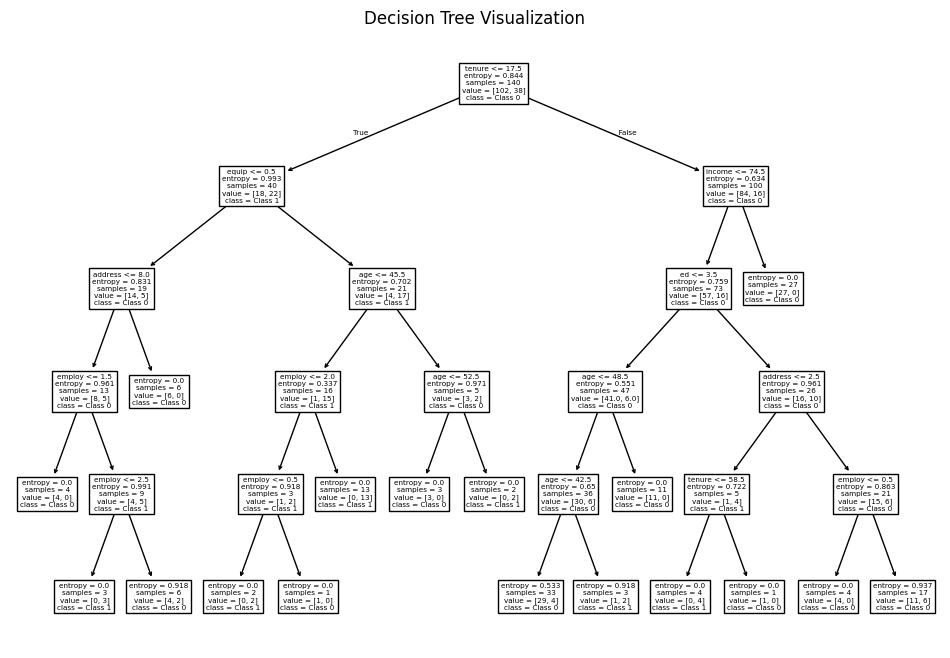

In [22]:
# Adjust the tree plot without 'filled' argument if necessary
plt.figure(figsize=(12, 8))
plot_tree(Tree, 
          feature_names=X.columns,  # Make sure this is a DataFrame; replace with list if it's not
          class_names=['Class 0', 'Class 1'])  # Replace with actual class names

plt.title('Decision Tree Visualization')
plt.savefig("tree.png")
plt.show()

We can repeat the process but sampling different data points from the same dataset.  We see the tree still suffers from overfitting; in addition, the new tree is entirely different.


{'test Accuracy': 0.65, 'train Accuracy': 0.9357142857142857}


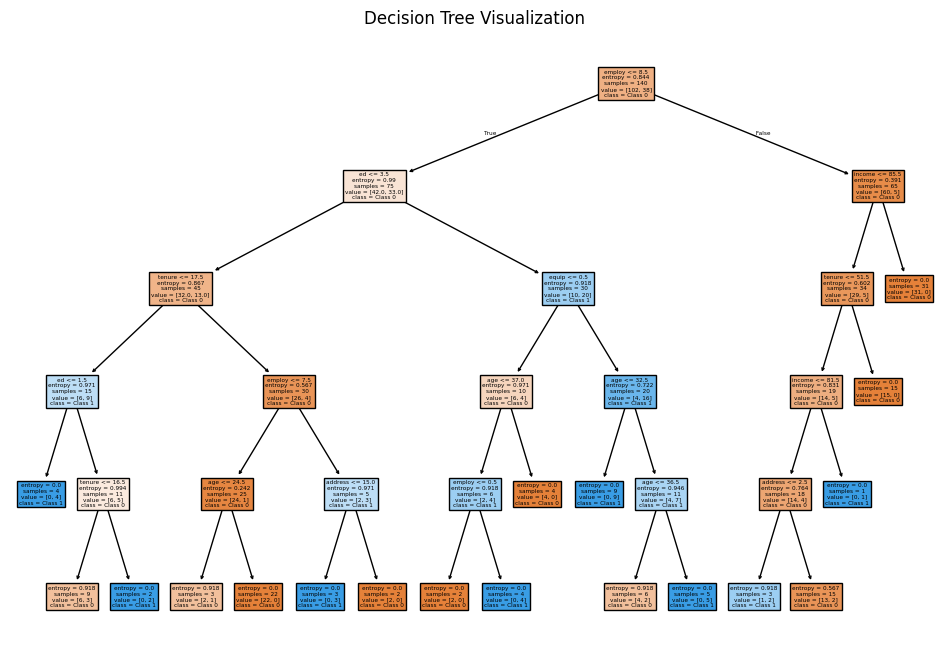

In [23]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.3, random_state=5)
Tree = DecisionTreeClassifier(criterion="entropy", max_depth = max_depth,random_state=8)
Tree.fit(X_train,y_train)
print(get_accuracy(X_train, X_test, y_train, y_test,  Tree))
plt.figure(figsize=(12, 8))  # Set figure size
plot_tree(Tree, 
          filled=True, 
          feature_names=X.columns,  # Replace with actual feature names if X is not a DataFrame
          class_names=['Class 0', 'Class 1'])  # Replace with actual class names

# Save the tree as an image
plt.title('Decision Tree Visualization')
plt.savefig("tree1.png")
plt.show()

<h2 id="evaluation">Bagging  for classification with  Scikit-learn</h2>
A Bagging classifier is an ensemble model that trains  base classifiers  on random subsets   of the original dataset  (Bootstrap Sampling by default), and then aggregate their individual predictions by voting. We import the module:


In [24]:
from sklearn.ensemble import BaggingClassifier

Bagging improves models that suffer from overfitting; they do well on the training data, but they do not Generalize well. Decision Trees are a prime candidate for this reason, in addition, they are fast to train; We create a <code>BaggingClassifier</code> object,  with a Decision Tree as the <code>estimator</code>


In [25]:
Bag = BaggingClassifier(estimator=DecisionTreeClassifier(criterion="entropy", max_depth = 4,random_state=2),n_estimators=30,random_state=0,bootstrap=True)

We fit the model:


In [26]:
Bag.fit(X_train,y_train)

BaggingClassifier(estimator=DecisionTreeClassifier(criterion='entropy',
                                                   max_depth=4,
                                                   random_state=2),
                  n_estimators=30, random_state=0)

The method <code>predict</code>  aggregates the predictions by voting:


In [27]:
Bag.predict(X_test)

array([0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0,
       1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1])

We see the training accuracy is slightly better but the test accuracy improves  dramatically:


In [28]:
print(get_accuracy(X_train, X_test, y_train, y_test,  Bag))

{'test Accuracy': 0.7, 'train Accuracy': 0.9071428571428571}


Here we can see the impact of adding more estimators (Decision Trees) using in Bagging on the testing and training accuracy


100%|██████████| 20/20 [01:14<00:00,  3.73s/it]


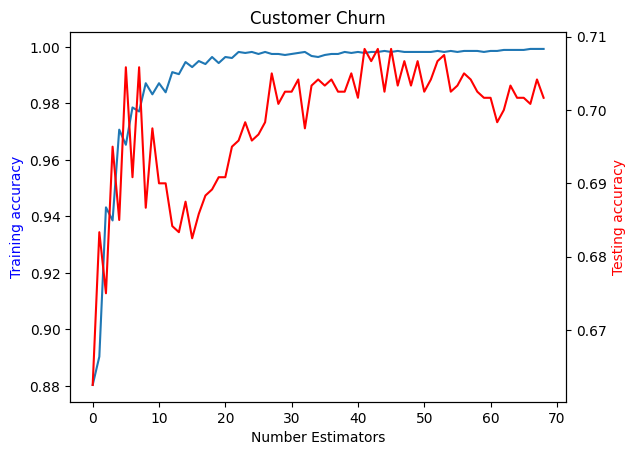

In [29]:
get_accuracy_bag(X, y, "Customer Churn")

## Low Variance Example


Bagging does not improve result if the model has low Variance i.e. does reasonably well on the test and training data. Consider the SVM; the accuracy on the tests data and training data are similar


In [30]:
from sklearn.svm import SVC

clf=SVC(kernel='linear',gamma='scale')
clf.fit(X_train, y_train) 
print(get_accuracy(X_train, X_test, y_train, y_test,  clf))

{'test Accuracy': 0.7166666666666667, 'train Accuracy': 0.7642857142857142}


Bagging the SVM does almost nothing:


In [31]:
Bag = BaggingClassifier(estimator=SVC(kernel='linear',gamma='scale'),n_estimators=10,random_state=0,bootstrap=True)
Bag.fit(X_train,y_train)
print(get_accuracy(X_train, X_test, y_train, y_test,  Bag))

{'test Accuracy': 0.7, 'train Accuracy': 0.7785714285714286}


<h2 id="practice">Practice: Cancer data</h2>

The example is based on a dataset that is publicly available from the UCI Machine Learning Repository (Asuncion and Newman, 2007)[[http://mlearn.ics.uci.edu/MLRepository.html](http://mlearn.ics.uci.edu/MLRepository.html?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMML241ENSkillsNetwork31576874-2022-01-01)]. The dataset consists of several hundred human cell sample records, each of which contains the values of a set of cell characteristics. The fields in each record are:

| Field name  | Description                 |
| ----------- | --------------------------- |
| ID          | Clump thickness             |
| Clump       | Clump thickness             |
| UnifSize    | Uniformity of cell size     |
| UnifShape   | Uniformity of cell shape    |
| MargAdh     | Marginal adhesion           |
| SingEpiSize | Single epithelial cell size |
| BareNuc     | Bare nuclei                 |
| BlandChrom  | Bland chromatin             |
| NormNucl    | Normal nucleoli             |
| Mit         | Mitoses                     |
| Class       | Benign or malignant         |

<br>
<br>

Let's load the dataset:


In [32]:
df = pd.read_csv("https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/Module%203/data/cell_samples.csv")

df.head()

,ID,Clump,UnifSize,UnifShape,MargAdh,SingEpiSize,BareNuc,BlandChrom,NormNucl,Mit,Class
0,1000025,5,1,1,1,2,1,3,1,1,2
1,1002945,5,4,4,5,7,10,3,2,1,2
2,1015425,3,1,1,1,2,2,3,1,1,2
3,1016277,6,8,8,1,3,4,3,7,1,2
4,1017023,4,1,1,3,2,1,3,1,1,2


Now lets remove rows that have a ? in the `BareNuc` column


In [33]:
df = df[df["BareNuc"] != "?"]

Now lets define the X and y for our dataset


In [34]:
X =  df[['Clump', 'UnifSize', 'UnifShape', 'MargAdh', 'SingEpiSize', 'BareNuc', 'BlandChrom', 'NormNucl', 'Mit']]

X.head()

,Clump,UnifSize,UnifShape,MargAdh,SingEpiSize,BareNuc,BlandChrom,NormNucl,Mit
0,5,1,1,1,2,1,3,1,1
1,5,4,4,5,7,10,3,2,1
2,3,1,1,1,2,2,3,1,1
3,6,8,8,1,3,4,3,7,1
4,4,1,1,3,2,1,3,1,1


In [35]:
y = df['Class']

y.head()

0    2
1    2
2    2
3    2
4    2
Name: Class, dtype: int64

Now lets split our data into training and testing data with a 80/20 split


In [36]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (546, 9) (546,)
Test set: (137, 9) (137,)


Now to determine the best parameters for `n_estimators` and the `max_depth` of the `estimator` we will use `GridSearchCV`


In [37]:
from sklearn.model_selection import GridSearchCV

We can use GridSearch for Exhaustive search over specified parameter values. To  alter the base  model; we add the double underscore and the attribute value:

Here we are searching odd numbers from 1 to 39 for `n_estimators` and odd numbers from 1 to 20 for `max_depth` in the `estimator`


In [38]:
param_grid = {'n_estimators': [2*n+1 for n in range(20)],
     'estimator__max_depth' : [2*n+1 for n in range(10) ] }

Create a `BaggingClassifier` object called `Bag` with the `estimator` set to a `DecisionTreeClassifier` object where `random_state` = 0 and `bootstrap` = True


In [39]:
Bag = BaggingClassifier(estimator = DecisionTreeClassifier(), random_state=0, bootstrap=True)

<details><summary>Click here for the solution</summary>

```python
Bag = BaggingClassifier(estimator = DecisionTreeClassifier(), random_state=0, bootstrap=True)
```

</details>


Now we create a `GridSearchCV` object and search for the best parameters according to our `parameter_grid`


In [40]:
search = GridSearchCV(estimator=Bag, param_grid=param_grid, scoring='accuracy', cv=3)

In [41]:
search.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=BaggingClassifier(estimator=DecisionTreeClassifier(),
                                         random_state=0),
             param_grid={'estimator__max_depth': [1, 3, 5, 7, 9, 11, 13, 15, 17,
                                                  19],
                         'n_estimators': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21,
                                          23, 25, 27, 29, 31, 33, 35, 37, 39]},
             scoring='accuracy')

We can see the best accuracy score of the searched parameters was ~97%


In [42]:
search.best_score_

np.float64(0.9688644688644689)

We can also see the parameters that resulted in the best score


In [43]:
search.best_params_

{'estimator__max_depth': 5, 'n_estimators': 11}

And we can see the testing and training accuracy of the best estimator


In [44]:
print(get_accuracy(X_train, X_test, y_train, y_test, search.best_estimator_))

{'test Accuracy': 0.9708029197080292, 'train Accuracy': 0.9853479853479854}


Below we can see a graph of testing and training accuracy holding the `max_depth` of the `estimator` at 10 and varying the number of estimators. We can see that it is extremely close to the accuracy of the `best_estimator` we found using `GridSearchCV`


100%|██████████| 20/20 [01:34<00:00,  4.72s/it]


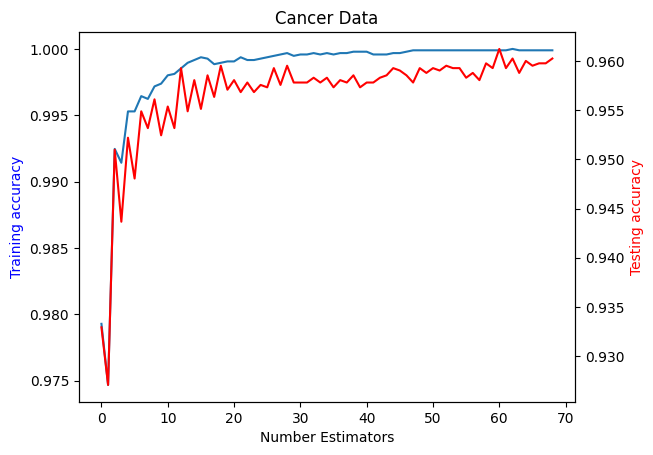

In [45]:
get_accuracy_bag(X, y, "Cancer Data")

<h2 id="practice">Practice: During their course of treatment</h2>


Imagine that you are a medical researcher compiling data for a study. You have collected data about a set of patients, all of whom suffered from the same illness. During their course of treatment, each patient responded to one of 5 medications, Drug A, Drug B, Drug c, Drug x and y.

Part of your job is to build a model to find out which drug might be appropriate for a future patient with the same illness. The features of this dataset are Age, Sex, Blood Pressure, and the Cholesterol of the patients, and the target is the drug that each patient responded to.

It is a sample of multiclass classifier, and you can use the training part of the dataset to build a decision tree, and then use it to predict the class of a unknown patient, or to prescribe a drug to a new patient.


In [46]:
df = pd.read_csv("https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/Module%203/data/drug200.csv", delimiter=",")
df.head()

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,F,HIGH,HIGH,25.355,drugY
1,47,M,LOW,HIGH,13.093,drugC
2,47,M,LOW,HIGH,10.114,drugC
3,28,F,NORMAL,HIGH,7.798,drugX
4,61,F,LOW,HIGH,18.043,drugY


Lets create the X and y for our dataset


In [47]:
X = df[['Age', 'Sex', 'BP', 'Cholesterol', 'Na_to_K']].values
X[0:5]

array([[23, 'F', 'HIGH', 'HIGH', 25.355],
       [47, 'M', 'LOW', 'HIGH', 13.093],
       [47, 'M', 'LOW', 'HIGH', 10.114],
       [28, 'F', 'NORMAL', 'HIGH', 7.798],
       [61, 'F', 'LOW', 'HIGH', 18.043]], dtype=object)

In [48]:
y = df["Drug"]
y[0:5]

0    drugY
1    drugC
2    drugC
3    drugX
4    drugY
Name: Drug, dtype: object

Now lets use a `LabelEncoder` to turn categorical features into numerical


In [49]:
le_sex = preprocessing.LabelEncoder()
le_sex.fit(['F','M'])
X[:,1] = le_sex.transform(X[:,1]) 

In [50]:
le_BP = preprocessing.LabelEncoder()
le_BP.fit([ 'LOW', 'NORMAL', 'HIGH'])
X[:,2] = le_BP.transform(X[:,2])

In [51]:
le_Chol = preprocessing.LabelEncoder()
le_Chol.fit([ 'NORMAL', 'HIGH'])
X[:,3] = le_Chol.transform(X[:,3]) 

In [52]:
X[0:5]

array([[23, 0, 0, 0, 25.355],
       [47, 1, 1, 0, 13.093],
       [47, 1, 1, 0, 10.114],
       [28, 0, 2, 0, 7.798],
       [61, 0, 1, 0, 18.043]], dtype=object)

Split the data into training and testing data with a 80/20 split


In [53]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (160, 5) (160,)
Test set: (40, 5) (40,)


Using the same parameter grid as before


In [54]:
param_grid = {'n_estimators': [2*n+1 for n in range(20)],
     'estimator__max_depth' : [2*n+1 for n in range(10) ]}

Create a `BaggingClassifier` object called `Bag` with the `estimator` set to a `DecisionTreeClassifier` object where `random_state` = 0 and `bootstrap` = True


In [55]:
# add your code below
Bag = BaggingClassifier(estimator=DecisionTreeClassifier(),random_state=0,bootstrap=True)

<details><summary>Click here for the solution</summary>

```python
Bag = BaggingClassifier(estimator=DecisionTreeClassifier(),random_state=0,bootstrap=True)

```

</details>


Create `GridSearchCV` object called `search` with the `estimator` set to `Bag`, `param_grid` set to `param_grid`, `scoring` set to `accuracy`, and `cv` set to 3.


In [56]:
# add your code below
search = GridSearchCV(estimator=Bag, param_grid=param_grid,scoring='accuracy', cv=3)

<details><summary>Click here for the solution</summary>

```python
search = GridSearchCV(estimator=Bag, param_grid=param_grid,scoring='accuracy', cv=3)

```

</details>


Fit the `GridSearchCV` object to our `X_train` and `y_train` data


In [57]:
# add your code below
search.fit(X_train, y_train)

c:\Users\default.ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\ma\core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


GridSearchCV(cv=3,
             estimator=BaggingClassifier(estimator=DecisionTreeClassifier(),
                                         random_state=0),
             param_grid={'estimator__max_depth': [1, 3, 5, 7, 9, 11, 13, 15, 17,
                                                  19],
                         'n_estimators': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21,
                                          23, 25, 27, 29, 31, 33, 35, 37, 39]},
             scoring='accuracy')

<details><summary>Click here for the solution</summary>

```python
search.fit(X_train, y_train)
```

</details>


After using `fit` we can see the best score and parameters


In [58]:
search.best_score_

np.float64(1.0)

In [59]:
search.best_params_

{'estimator__max_depth': 5, 'n_estimators': 9}

In [60]:
print(get_accuracy(X_train, X_test, y_train, y_test, search.best_estimator_))

{'test Accuracy': 0.95, 'train Accuracy': 1.0}


Below we can see a graph of testing and training accuracy holding the max_depth of the estimator at 10 and varying the number of estimators. We can see that it is extremely close to the accuracy of the best_estimator we found using GridSearchCV


100%|██████████| 20/20 [01:22<00:00,  4.12s/it]


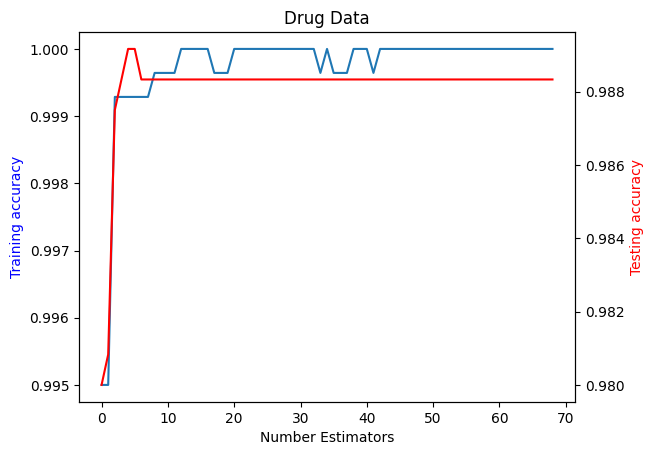

In [61]:
get_accuracy_bag(X, y, "Drug Data")

<h2>Want to learn more?</h2>

IBM SPSS Modeler is a comprehensive analytics platform that has many machine learning algorithms. It has been designed to bring predictive intelligence to decisions made by individuals, by groups, by systems – by your enterprise as a whole. A free trial is available through this course, available here: <a href="https://www.ibm.com/analytics/spss-statistics-software?utm_source=Exinfluencer&utm_content=000026UJ&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML0101ENSkillsNetwork20718538-2021-01-01&utm_medium=Exinfluencer&utm_term=10006555">SPSS Modeler</a>

Also, you can use Watson Studio to run these notebooks faster with bigger datasets. Watson Studio is IBM's leading cloud solution for data scientists, built by data scientists. With Jupyter notebooks, RStudio, Apache Spark and popular libraries pre-packaged in the cloud, Watson Studio enables data scientists to collaborate on their projects without having to install anything. Join the fast-growing community of Watson Studio users today with a free account at <a href="https://www.ibm.com/cloud/watson-studio?utm_source=Exinfluencer&utm_content=000026UJ&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML0101ENSkillsNetwork20718538-2021-01-01&utm_medium=Exinfluencer&utm_term=10006555">Watson Studio</a>


### Thank you for completing this lab!

## Author

<a href="https://www.linkedin.com/in/joseph-s-50398b136/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML0101ENSkillsNetwork20718538-2021-01-01" target="_blank">Joseph Santarcangelo</a>

## Other Contributors

<a href="https://www.linkedin.com/in/richard-ye/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML0101ENSkillsNetwork20718538-2021-01-01" target="_blank">Richard Ye</a>

## <h3 align="center"> © IBM Corporation 2020. All rights reserved. <h3/>

<!--## Change Log

| Date (YYYY-MM-DD) | Version | Changed By | Change Description |
| ----------------- | ------- | ---------- | ------------------ |
| 2022-01-19        | 0.1     | Joseph Santarcangelo | Created Lab Template |
| 2022-05-03        | 0.2     | Richard Ye           | QA pass              |--!>



